In [8]:
import sys
sys.path.append('../../')

from utils.Library import *
from utils.DataLoader import load_data

cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

train_df, test_df = load_data(
    train_path='../../data/train_8000_final.p',
    test_path='../../data/test_2000_final.p',
    cols_to_drop=cols_to_drop
)

In [9]:
def get_input_data(df_train, df_test, input_type, target, emb='hist_emb'):
    if input_type == "clinical_symptoms_text":
        X_train = np.array(df_train.iloc[:, :12].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, :12].drop(columns=target, errors='ignore'))
        X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
        X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)
    elif input_type == "clinical_symptoms":
        X_train = np.array(df_train.iloc[:, :12].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, :12].drop(columns=target, errors='ignore'))
    elif input_type == "clinical_text":
        X_train = np.array(df_train.iloc[:, 0:5].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, 0:5].drop(columns=target, errors='ignore'))
        X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
        X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)
    elif input_type == "clinical":
        X_train = np.array(df_train.iloc[:, :5].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, :5].drop(columns=target, errors='ignore'))
    elif input_type == "symptoms":
        X_train = np.array(df_train.iloc[:, 7:12].drop(columns=target, errors='ignore'))
        X_test = np.array(df_test.iloc[:, 7:12].drop(columns=target, errors='ignore'))
    elif input_type == "text":
        X_train = np.array(df_train[emb].tolist())
        X_test = np.array(df_test[emb].tolist())
    else:
        raise ValueError(f"Unknown input_type: {input_type}")
    
    return X_train, X_test


In [10]:
def NN_model_train(target, df_train, df_test, input_type='clinical_symptoms_text', emb='hist_emb'):
    # Lấy dữ liệu input theo kiểu lựa chọn
    X_train, X_test = get_input_data(df_train, df_test, input_type=input_type, target=target, emb=emb)

    y_train = df_train[target].values
    y_true = df_test[target].values  

    print("y_train shape:", y_train.shape)
    print("Input features:", X_train.shape[1])

    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Đã sửa sigmoid cho binary
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    print("Class Weights:", class_weights)

    model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, class_weight=class_weights)

    y_pred = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    y_pred = model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    return model, roc_auc, fpr, tpr, recall, precision



In [11]:
input_types = ['symptoms', 'clinical', 'clinical_symptoms', 'clinical_text', 'clinical_symptoms_text']
all_results = {}

for input_type in input_types:
    print(f"\n Running input_type: {input_type}")
    best_pr_auc = -1
    best_result = None

    for seed in [21, 2, 13, 3, 2023]:
        print(f"  ➤ Seed {seed}")
        np.random.seed(seed)
        tf.random.set_seed(seed)

        model, roc_auc, fpr, tpr, recall, precision = NN_model_train(
            target='pneu',
            df_train=train_df,
            df_test=test_df,
            input_type=input_type,
            emb='hist_emb'
        )

        pr_auc = auc(recall, precision)

        if pr_auc > best_pr_auc:
            best_pr_auc = pr_auc
            best_result = {
                'seed': seed,
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'fpr': fpr,
                'tpr': tpr,
                'recall': recall,
                'precision': precision
            }

    all_results[input_type] = best_result




 Running input_type: symptoms
  ➤ Seed 21
y_train shape: (8000,)
Input features: 5


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9046 - loss: 0.6015 - val_accuracy: 0.8225 - val_loss: 0.3750
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8533 - loss: 0.2904 - val_accuracy: 0.9112 - val_loss: 0.2613
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9180 - loss: 0.2548 - val_accuracy: 0.9287 - val_loss: 0.2531
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9177 - loss: 0.2486 - val_accuracy: 0.9287 - val_loss: 0.2515
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9183 - loss: 0.2446 - val_accuracy: 0.9287 - val_loss: 0.2480
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9182 - loss: 0.2417 - val_accuracy: 0.9287 - val_loss: 0.2468
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9187 - loss: 0.2393 - val_accuracy: 0.9287 - val_loss: 0.2477
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7936 - loss: 0.5892 - val_accuracy: 0.9256 - val_loss: 0.2562
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9150 - loss: 0.2806 - val_accuracy: 0.9375 - val_loss: 0.1574
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9235 - loss: 0.2448 - val_accuracy: 0.9350 - val_loss: 0.1710
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.2427 - val_accuracy: 0.9294 - val_loss: 0.1929
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.2433 - val_accuracy: 0.9294 - val_loss: 0.2137
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.2424 - val_accuracy: 0.9294 - val_loss: 0.2200
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.2417 - val_accuracy: 0.9294 - val_loss: 0.2235
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8496 - loss: 0.5818 - val_accuracy: 0.8069 - val_loss: 0.4138
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8285 - loss: 0.2974 - val_accuracy: 0.9112 - val_loss: 0.2823
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9033 - loss: 0.2362 - val_accuracy: 0.9287 - val_loss: 0.2560
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9137 - loss: 0.2247 - val_accuracy: 0.9287 - val_loss: 0.2441
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9164 - loss: 0.2199 - val_accuracy: 0.9287 - val_loss: 0.2340
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9161 - loss: 0.2166 - val_accuracy: 0.9287 - val_loss: 0.2271
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9151 - loss: 0.2138 - val_accuracy: 0.9306 - val_loss: 0.2225
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6755 - loss: 0.5636 - val_accuracy: 0.8250 - val_loss: 0.3883
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8827 - loss: 0.2674 - val_accuracy: 0.9112 - val_loss: 0.3320
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9133 - loss: 0.2413 - val_accuracy: 0.9262 - val_loss: 0.3131
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9153 - loss: 0.2366 - val_accuracy: 0.9175 - val_loss: 0.3054
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9114 - loss: 0.2330 - val_accuracy: 0.9175 - val_loss: 0.2997
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9083 - loss: 0.2312 - val_accuracy: 0.9175 - val_loss: 0.2832
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9057 - loss: 0.2288 - val_accuracy: 0.9175 - val_loss: 0.2800
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7846 - loss: 0.5732 - val_accuracy: 0.9219 - val_loss: 0.2916
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9059 - loss: 0.2894 - val_accuracy: 0.9350 - val_loss: 0.1973
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9156 - loss: 0.2433 - val_accuracy: 0.9350 - val_loss: 0.1797
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9164 - loss: 0.2373 - val_accuracy: 0.9350 - val_loss: 0.1742
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9164 - loss: 0.2349 - val_accuracy: 0.9350 - val_loss: 0.1746
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9162 - loss: 0.2326 - val_accuracy: 0.9350 - val_loss: 0.1725
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9161 - loss: 0.2312 - val_accuracy: 0.9350 - val_loss: 0.1726
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8820 - loss: 0.6546 - val_accuracy: 0.5119 - val_loss: 0.7526
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5264 - loss: 0.6357 - val_accuracy: 0.5169 - val_loss: 0.7136
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5303 - loss: 0.6265 - val_accuracy: 0.5169 - val_loss: 0.6990
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5367 - loss: 0.6222 - val_accuracy: 0.5169 - val_loss: 0.6823
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5655 - loss: 0.6202 - val_accuracy: 0.5169 - val_loss: 0.6870
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.6189 - val_accuracy: 0.5169 - val_loss: 0.6782
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6410 - loss: 0.6177 - val_accuracy: 0.6019 - val_loss: 0.6726
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6016 - loss: 0.7115 - val_accuracy: 0.5144 - val_loss: 0.7357
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4970 - loss: 0.6841 - val_accuracy: 0.5194 - val_loss: 0.6446
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6716 - loss: 0.6804 - val_accuracy: 0.6019 - val_loss: 0.6369
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6956 - loss: 0.6766 - val_accuracy: 0.6019 - val_loss: 0.6304
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6995 - loss: 0.6773 - val_accuracy: 0.6019 - val_loss: 0.6251
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7074 - loss: 0.6765 - val_accuracy: 0.6019 - val_loss: 0.6294
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7125 - loss: 0.6761 - val_accuracy: 0.6019 - val_loss: 0.6278
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9082 - loss: 0.6515 - val_accuracy: 0.4594 - val_loss: 0.7066
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4652 - loss: 0.6178 - val_accuracy: 0.4594 - val_loss: 0.6823
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4729 - loss: 0.6074 - val_accuracy: 0.5169 - val_loss: 0.6654
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4924 - loss: 0.6029 - val_accuracy: 0.5169 - val_loss: 0.6605
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5046 - loss: 0.5996 - val_accuracy: 0.5169 - val_loss: 0.6581
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5307 - loss: 0.5979 - val_accuracy: 0.6019 - val_loss: 0.6520
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5848 - loss: 0.5963 - val_accuracy: 0.6019 - val_loss: 0.6534
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_99 (Dense)                │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3887 - loss: 0.7163 - val_accuracy: 0.4563 - val_loss: 0.7275
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4582 - loss: 0.6927 - val_accuracy: 0.6044 - val_loss: 0.6708
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5240 - loss: 0.6878 - val_accuracy: 0.6044 - val_loss: 0.6390
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5328 - loss: 0.6804 - val_accuracy: 0.6019 - val_loss: 0.6301
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5512 - loss: 0.6736 - val_accuracy: 0.6019 - val_loss: 0.6285
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5725 - loss: 0.6708 - val_accuracy: 0.6019 - val_loss: 0.6283
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5763 - loss: 0.6702 - val_accuracy: 0.6019 - val_loss: 0.6255
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7933 - loss: 0.7029 - val_accuracy: 0.5144 - val_loss: 0.6967
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5183 - loss: 0.6636 - val_accuracy: 0.5169 - val_loss: 0.6635
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5192 - loss: 0.6522 - val_accuracy: 0.5169 - val_loss: 0.6503
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5367 - loss: 0.6477 - val_accuracy: 0.5169 - val_loss: 0.6473
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5537 - loss: 0.6453 - val_accuracy: 0.6019 - val_loss: 0.6420
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5787 - loss: 0.6438 - val_accuracy: 0.5169 - val_loss: 0.6476
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5774 - loss: 0.6434 - val_accuracy: 0.6019 - val_loss: 0.6406
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8459 - loss: 0.5563 - val_accuracy: 0.8600 - val_loss: 0.3403
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8928 - loss: 0.2799 - val_accuracy: 0.9294 - val_loss: 0.2222
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9216 - loss: 0.2331 - val_accuracy: 0.9262 - val_loss: 0.2180
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9269 - loss: 0.2142 - val_accuracy: 0.9262 - val_loss: 0.2149
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9276 - loss: 0.2033 - val_accuracy: 0.9287 - val_loss: 0.2096
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9304 - loss: 0.1909 - val_accuracy: 0.9269 - val_loss: 0.2149
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9314 - loss: 0.1839 - val_accuracy: 0.9331 - val_loss: 0.2109
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7427 - loss: 0.5510 - val_accuracy: 0.8550 - val_loss: 0.3116
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8616 - loss: 0.3010 - val_accuracy: 0.9688 - val_loss: 0.1277
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9333 - loss: 0.2387 - val_accuracy: 0.9706 - val_loss: 0.0980
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9430 - loss: 0.2209 - val_accuracy: 0.9706 - val_loss: 0.0925
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9443 - loss: 0.2080 - val_accuracy: 0.9712 - val_loss: 0.0936
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9464 - loss: 0.1984 - val_accuracy: 0.9675 - val_loss: 0.0991
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9459 - loss: 0.1895 - val_accuracy: 0.9588 - val_loss: 0.1078
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9227 - loss: 0.6189 - val_accuracy: 0.8313 - val_loss: 0.3634
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8308 - loss: 0.3006 - val_accuracy: 0.9150 - val_loss: 0.2468
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9013 - loss: 0.2226 - val_accuracy: 0.9262 - val_loss: 0.2191
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9058 - loss: 0.2006 - val_accuracy: 0.9237 - val_loss: 0.2107
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9118 - loss: 0.1882 - val_accuracy: 0.9269 - val_loss: 0.1963
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9174 - loss: 0.1786 - val_accuracy: 0.9350 - val_loss: 0.1895
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9227 - loss: 0.1723 - val_accuracy: 0.9413 - val_loss: 0.1847
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5865 - loss: 0.5584 - val_accuracy: 0.8200 - val_loss: 0.4399
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8401 - loss: 0.2852 - val_accuracy: 0.9062 - val_loss: 0.3191
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9051 - loss: 0.2260 - val_accuracy: 0.9050 - val_loss: 0.3046
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9108 - loss: 0.2090 - val_accuracy: 0.9175 - val_loss: 0.2831
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9111 - loss: 0.2000 - val_accuracy: 0.9181 - val_loss: 0.2683
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9131 - loss: 0.1949 - val_accuracy: 0.9150 - val_loss: 0.2638
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9170 - loss: 0.1900 - val_accuracy: 0.9294 - val_loss: 0.2569
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8026 - loss: 0.5749 - val_accuracy: 0.8838 - val_loss: 0.2566
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8785 - loss: 0.2947 - val_accuracy: 0.9413 - val_loss: 0.1666
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9227 - loss: 0.2271 - val_accuracy: 0.9575 - val_loss: 0.1452
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9315 - loss: 0.2073 - val_accuracy: 0.9581 - val_loss: 0.1405
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9359 - loss: 0.1962 - val_accuracy: 0.9581 - val_loss: 0.1430
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9396 - loss: 0.1895 - val_accuracy: 0.9531 - val_loss: 0.1406
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9384 - loss: 0.1826 - val_accuracy: 0.9525 - val_loss: 0.1421
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9508 - loss: 0.6052 - val_accuracy: 0.7075 - val_loss: 0.4487
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8102 - loss: 0.4293 - val_accuracy: 0.7887 - val_loss: 0.4031
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8403 - loss: 0.3456 - val_accuracy: 0.7962 - val_loss: 0.3978
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8657 - loss: 0.2877 - val_accuracy: 0.8169 - val_loss: 0.3734
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8844 - loss: 0.2443 - val_accuracy: 0.8525 - val_loss: 0.3139
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9092 - loss: 0.2047 - val_accuracy: 0.8800 - val_loss: 0.2693
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9257 - loss: 0.1635 - val_accuracy: 0.8994 - val_loss: 0.2473
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step -

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_123 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7142 - loss: 0.6378 - val_accuracy: 0.9275 - val_loss: 0.2316
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8139 - loss: 0.3977 - val_accuracy: 0.9206 - val_loss: 0.2292
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8641 - loss: 0.3216 - val_accuracy: 0.9344 - val_loss: 0.2043
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8940 - loss: 0.2698 - val_accuracy: 0.9325 - val_loss: 0.1893
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9112 - loss: 0.2254 - val_accuracy: 0.9381 - val_loss: 0.1700
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9281 - loss: 0.1849 - val_accuracy: 0.9463 - val_loss: 0.1443
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9420 - loss: 0.1519 - val_accuracy: 0.9513 - val_loss: 0.1274
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step -

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9141 - loss: 0.6248 - val_accuracy: 0.6275 - val_loss: 0.5374
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6841 - loss: 0.4667 - val_accuracy: 0.6344 - val_loss: 0.6113
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7572 - loss: 0.3693 - val_accuracy: 0.7044 - val_loss: 0.5559
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8060 - loss: 0.3127 - val_accuracy: 0.7831 - val_loss: 0.4463
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8420 - loss: 0.2629 - val_accuracy: 0.8106 - val_loss: 0.3909
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8651 - loss: 0.2281 - val_accuracy: 0.8475 - val_loss: 0.3280
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8843 - loss: 0.1932 - val_accuracy: 0.8856 - val_loss: 0.2661
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step -

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_129 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6003 - loss: 0.6530 - val_accuracy: 0.6344 - val_loss: 0.6634
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8012 - loss: 0.4027 - val_accuracy: 0.6675 - val_loss: 0.6708
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8372 - loss: 0.3261 - val_accuracy: 0.7025 - val_loss: 0.6364
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8619 - loss: 0.2786 - val_accuracy: 0.7506 - val_loss: 0.5627
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8837 - loss: 0.2334 - val_accuracy: 0.7931 - val_loss: 0.4883
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9087 - loss: 0.1941 - val_accuracy: 0.8300 - val_loss: 0.4226
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9236 - loss: 0.1588 - val_accuracy: 0.8662 - val_loss: 0.3489
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8763 - loss: 0.6488 - val_accuracy: 0.8250 - val_loss: 0.3528
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7969 - loss: 0.4813 - val_accuracy: 0.8856 - val_loss: 0.2676
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8485 - loss: 0.3800 - val_accuracy: 0.9025 - val_loss: 0.2331
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8715 - loss: 0.3178 - val_accuracy: 0.9169 - val_loss: 0.2062
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8927 - loss: 0.2637 - val_accuracy: 0.9319 - val_loss: 0.1764
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9124 - loss: 0.2125 - val_accuracy: 0.9463 - val_loss: 0.1487
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9299 - loss: 0.1641 - val_accuracy: 0.9588 - val_loss: 0.1123
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - ac

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9544 - loss: 0.5167 - val_accuracy: 0.9006 - val_loss: 0.2671
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9171 - loss: 0.2607 - val_accuracy: 0.9050 - val_loss: 0.2586
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9188 - loss: 0.2099 - val_accuracy: 0.9000 - val_loss: 0.2597
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9178 - loss: 0.1820 - val_accuracy: 0.9162 - val_loss: 0.2284
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9264 - loss: 0.1550 - val_accuracy: 0.9306 - val_loss: 0.1906
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9371 - loss: 0.1324 - val_accuracy: 0.9413 - val_loss: 0.1645
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9463 - loss: 0.1120 - val_accuracy: 0.9463 - val_loss: 0.1438
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - 

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8091 - loss: 0.5167 - val_accuracy: 0.9413 - val_loss: 0.1683
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9040 - loss: 0.2529 - val_accuracy: 0.9581 - val_loss: 0.1215
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9266 - loss: 0.2099 - val_accuracy: 0.9631 - val_loss: 0.1026
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9336 - loss: 0.1796 - val_accuracy: 0.9725 - val_loss: 0.0845
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9459 - loss: 0.1426 - val_accuracy: 0.9769 - val_loss: 0.0715
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9559 - loss: 0.1131 - val_accuracy: 0.9800 - val_loss: 0.0586
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9624 - loss: 0.0886 - val_accuracy: 0.9825 - val_loss: 0.0521
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_141 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9671 - loss: 0.5897 - val_accuracy: 0.7825 - val_loss: 0.4372
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8440 - loss: 0.2937 - val_accuracy: 0.8888 - val_loss: 0.3040
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9003 - loss: 0.2029 - val_accuracy: 0.9125 - val_loss: 0.2315
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9134 - loss: 0.1659 - val_accuracy: 0.9319 - val_loss: 0.1840
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9283 - loss: 0.1414 - val_accuracy: 0.9456 - val_loss: 0.1587
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9387 - loss: 0.1220 - val_accuracy: 0.9500 - val_loss: 0.1386
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9493 - loss: 0.1033 - val_accuracy: 0.9594 - val_loss: 0.1202
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8714 - loss: 0.5515 - val_accuracy: 0.7487 - val_loss: 0.5398
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8794 - loss: 0.2443 - val_accuracy: 0.8112 - val_loss: 0.4462
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9009 - loss: 0.2016 - val_accuracy: 0.8381 - val_loss: 0.3998
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9118 - loss: 0.1775 - val_accuracy: 0.8562 - val_loss: 0.3750
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9211 - loss: 0.1549 - val_accuracy: 0.8863 - val_loss: 0.3348
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9338 - loss: 0.1350 - val_accuracy: 0.8981 - val_loss: 0.2945
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9416 - loss: 0.1162 - val_accuracy: 0.9119 - val_loss: 0.2603
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9250 - loss: 0.5314 - val_accuracy: 0.9406 - val_loss: 0.1466
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9069 - loss: 0.2493 - val_accuracy: 0.9569 - val_loss: 0.1054
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9319 - loss: 0.1816 - val_accuracy: 0.9575 - val_loss: 0.1055
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9381 - loss: 0.1503 - val_accuracy: 0.9650 - val_loss: 0.0921
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9469 - loss: 0.1261 - val_accuracy: 0.9681 - val_loss: 0.0870
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9539 - loss: 0.1056 - val_accuracy: 0.9756 - val_loss: 0.0696
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9582 - loss: 0.0922 - val_accuracy: 0.9775 - val_loss: 0.0612
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - ac


🎯 Best results by input_type (based on PR AUC):
  - symptoms       : Seed = 2, ROC AUC = 0.9679, PR AUC = 0.2974
  - clinical       : Seed = 3, ROC AUC = 0.6119, PR AUC = 0.0110
  - clinical_symptoms: Seed = 2, ROC AUC = 0.9478, PR AUC = 0.3680
  - clinical_text  : Seed = 2, ROC AUC = 0.9733, PR AUC = 0.3856
  - clinical_symptoms_text: Seed = 3, ROC AUC = 0.9825, PR AUC = 0.6698


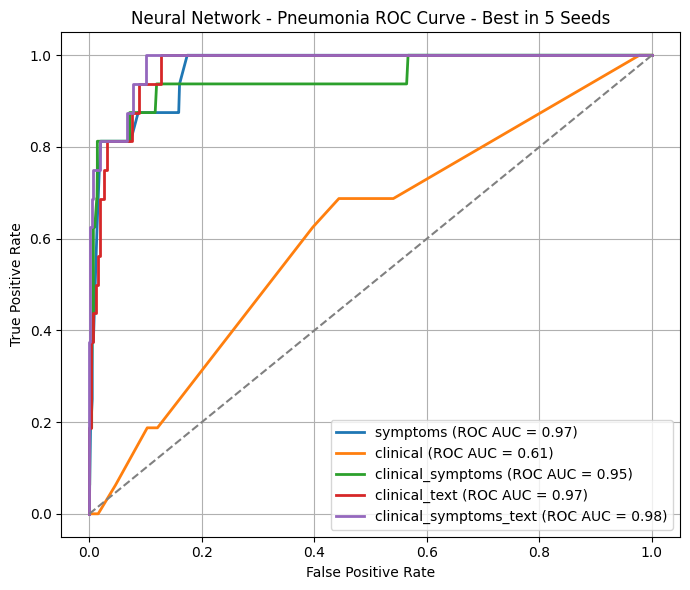

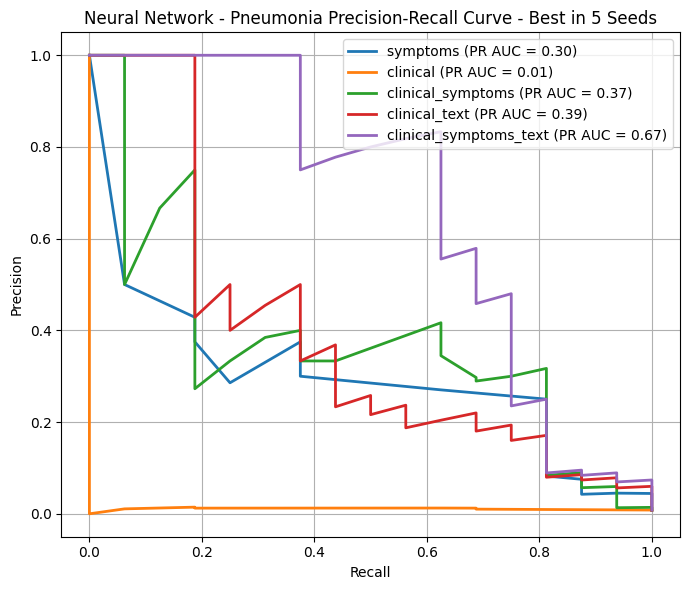

In [12]:
# In kết quả tốt nhất của mỗi input_type
print("\n🎯 Best results by input_type (based on PR AUC):")
for input_type, result in all_results.items():
    print(f"  - {input_type:15}: Seed = {result['seed']}, ROC AUC = {result['roc_auc']:.4f}, PR AUC = {result['pr_auc']:.4f}")

# === ROC CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['fpr'], result['tpr'], lw=2,
             label=f"{input_type} (ROC AUC = {result['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network - Pneumonia ROC Curve - Best in 5 Seeds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === PRECISION-RECALL CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['recall'], result['precision'], lw=2,
             label=f"{input_type} (PR AUC = {result['pr_auc']:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Neural Network - Pneumonia Precision-Recall Curve - Best in 5 Seeds")
plt.legend(loc="upper right")
plt.grid(True)
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 1, 6))
plt.tight_layout()
plt.show()



In [13]:
input_types = ['symptoms', 'clinical', 'clinical_symptoms', 'clinical_text', 'clinical_symptoms_text']
all_results = {}

for input_type in input_types:
    print(f"\n Running input_type: {input_type}")
    best_pr_auc = -1
    best_result = None

    for seed in [1,2,3,4,5]:
        print(f"  ➤ Seed {seed}")
        np.random.seed(seed)
        tf.random.set_seed(seed)

        model, roc_auc, fpr, tpr, recall, precision = NN_model_train(
            target='inf',
            df_train=train_df,
            df_test=test_df,
            input_type=input_type,
            emb='hist_emb'
        )

        pr_auc = auc(recall, precision)

        if pr_auc > best_pr_auc:
            best_pr_auc = pr_auc
            best_result = {
                'seed': seed,
                'roc_auc': roc_auc,
                'pr_auc': pr_auc,
                'fpr': fpr,
                'tpr': tpr,
                'recall': recall,
                'precision': precision
            }

    all_results[input_type] = best_result




 Running input_type: symptoms
  ➤ Seed 1
y_train shape: (8000,)
Input features: 5


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5896 - loss: 0.6021 - val_accuracy: 0.8144 - val_loss: 0.4003
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8127 - loss: 0.3811 - val_accuracy: 0.8050 - val_loss: 0.3659
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8116 - loss: 0.3742 - val_accuracy: 0.8050 - val_loss: 0.3639
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8128 - loss: 0.3727 - val_accuracy: 0.8050 - val_loss: 0.3629
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8131 - loss: 0.3720 - val_accuracy: 0.8075 - val_loss: 0.3620
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8146 - loss: 0.3716 - val_accuracy: 0.8075 - val_loss: 0.3614
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8147 - loss: 0.3713 - val_accuracy: 0.8100 - val_loss: 0.3610
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_153 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7509 - loss: 0.5770 - val_accuracy: 0.8019 - val_loss: 0.4236
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8081 - loss: 0.3770 - val_accuracy: 0.7981 - val_loss: 0.3982
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8049 - loss: 0.3750 - val_accuracy: 0.7981 - val_loss: 0.4022
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8045 - loss: 0.3747 - val_accuracy: 0.7981 - val_loss: 0.4028
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8059 - loss: 0.3744 - val_accuracy: 0.7981 - val_loss: 0.4039
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8065 - loss: 0.3743 - val_accuracy: 0.7981 - val_loss: 0.4043
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8064 - loss: 0.3741 - val_accuracy: 0.7981 - val_loss: 0.4040
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6475 - loss: 0.5526 - val_accuracy: 0.8150 - val_loss: 0.3972
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8223 - loss: 0.3790 - val_accuracy: 0.8081 - val_loss: 0.3594
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8172 - loss: 0.3671 - val_accuracy: 0.8131 - val_loss: 0.3550
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8167 - loss: 0.3653 - val_accuracy: 0.8131 - val_loss: 0.3525
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8175 - loss: 0.3645 - val_accuracy: 0.8131 - val_loss: 0.3511
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8178 - loss: 0.3640 - val_accuracy: 0.8131 - val_loss: 0.3501
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8176 - loss: 0.3636 - val_accuracy: 0.8131 - val_loss: 0.3496
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_159 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5843 - loss: 0.6000 - val_accuracy: 0.8100 - val_loss: 0.4319
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8140 - loss: 0.3801 - val_accuracy: 0.8050 - val_loss: 0.3820
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8095 - loss: 0.3663 - val_accuracy: 0.8050 - val_loss: 0.3787
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8119 - loss: 0.3650 - val_accuracy: 0.8050 - val_loss: 0.3775
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8138 - loss: 0.3642 - val_accuracy: 0.8050 - val_loss: 0.3769
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8149 - loss: 0.3638 - val_accuracy: 0.8050 - val_loss: 0.3768
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8149 - loss: 0.3635 - val_accuracy: 0.8050 - val_loss: 0.3765
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_162 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5636 - loss: 0.5870 - val_accuracy: 0.8075 - val_loss: 0.4689
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8114 - loss: 0.3919 - val_accuracy: 0.7981 - val_loss: 0.3878
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8015 - loss: 0.3763 - val_accuracy: 0.8050 - val_loss: 0.3819
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8033 - loss: 0.3742 - val_accuracy: 0.8050 - val_loss: 0.3801
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8058 - loss: 0.3732 - val_accuracy: 0.8050 - val_loss: 0.3784
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8077 - loss: 0.3727 - val_accuracy: 0.8050 - val_loss: 0.3776
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8080 - loss: 0.3723 - val_accuracy: 0.8075 - val_loss: 0.3768
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_165 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6138 - loss: 0.6277 - val_accuracy: 0.7669 - val_loss: 0.5412
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7664 - loss: 0.5010 - val_accuracy: 0.7669 - val_loss: 0.4996
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7664 - loss: 0.4956 - val_accuracy: 0.7669 - val_loss: 0.5009
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7664 - loss: 0.4947 - val_accuracy: 0.7669 - val_loss: 0.5007
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7664 - loss: 0.4943 - val_accuracy: 0.7669 - val_loss: 0.5007
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7664 - loss: 0.4941 - val_accuracy: 0.7669 - val_loss: 0.5007
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7664 - loss: 0.4939 - val_accuracy: 0.7669 - val_loss: 0.5003
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7232 - loss: 0.6081 - val_accuracy: 0.7669 - val_loss: 0.5284
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7764 - loss: 0.4893 - val_accuracy: 0.7669 - val_loss: 0.5183
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7764 - loss: 0.4861 - val_accuracy: 0.7669 - val_loss: 0.5192
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7764 - loss: 0.4855 - val_accuracy: 0.7669 - val_loss: 0.5194
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7764 - loss: 0.4852 - val_accuracy: 0.7669 - val_loss: 0.5189
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7764 - loss: 0.4850 - val_accuracy: 0.7669 - val_loss: 0.5188
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7764 - loss: 0.4848 - val_accuracy: 0.7669 - val_loss: 0.5186
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_171 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6817 - loss: 0.6079 - val_accuracy: 0.7669 - val_loss: 0.4962
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7725 - loss: 0.4929 - val_accuracy: 0.7669 - val_loss: 0.4847
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7725 - loss: 0.4898 - val_accuracy: 0.7669 - val_loss: 0.4864
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7725 - loss: 0.4891 - val_accuracy: 0.7669 - val_loss: 0.4870
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7725 - loss: 0.4887 - val_accuracy: 0.7669 - val_loss: 0.4872
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7725 - loss: 0.4885 - val_accuracy: 0.7669 - val_loss: 0.4877
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7725 - loss: 0.4883 - val_accuracy: 0.7669 - val_loss: 0.4874
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_174 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6563 - loss: 0.6319 - val_accuracy: 0.7663 - val_loss: 0.5096
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.4984 - val_accuracy: 0.7669 - val_loss: 0.4992
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7716 - loss: 0.4942 - val_accuracy: 0.7669 - val_loss: 0.5005
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7716 - loss: 0.4939 - val_accuracy: 0.7669 - val_loss: 0.5009
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.4937 - val_accuracy: 0.7669 - val_loss: 0.5014
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7716 - loss: 0.4936 - val_accuracy: 0.7669 - val_loss: 0.5020
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.4934 - val_accuracy: 0.7669 - val_loss: 0.5022
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_177 (Dense)               │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7142 - loss: 0.6196 - val_accuracy: 0.7669 - val_loss: 0.5310
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7767 - loss: 0.4813 - val_accuracy: 0.7669 - val_loss: 0.5236
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7767 - loss: 0.4819 - val_accuracy: 0.7669 - val_loss: 0.5227
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7767 - loss: 0.4819 - val_accuracy: 0.7669 - val_loss: 0.5223
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7767 - loss: 0.4818 - val_accuracy: 0.7669 - val_loss: 0.5219
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7767 - loss: 0.4817 - val_accuracy: 0.7669 - val_loss: 0.5216
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7767 - loss: 0.4816 - val_accuracy: 0.7669 - val_loss: 0.5214
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5586 - loss: 0.5566 - val_accuracy: 0.8944 - val_loss: 0.3319
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8968 - loss: 0.2958 - val_accuracy: 0.8950 - val_loss: 0.2887
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8966 - loss: 0.2827 - val_accuracy: 0.8956 - val_loss: 0.2758
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8977 - loss: 0.2774 - val_accuracy: 0.8956 - val_loss: 0.2711
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8975 - loss: 0.2747 - val_accuracy: 0.8944 - val_loss: 0.2685
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8976 - loss: 0.2729 - val_accuracy: 0.8944 - val_loss: 0.2666
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8975 - loss: 0.2715 - val_accuracy: 0.8963 - val_loss: 0.2651
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_183 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6975 - loss: 0.5544 - val_accuracy: 0.8913 - val_loss: 0.2900
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9038 - loss: 0.2791 - val_accuracy: 0.8906 - val_loss: 0.2661
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9030 - loss: 0.2704 - val_accuracy: 0.8906 - val_loss: 0.2646
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9053 - loss: 0.2677 - val_accuracy: 0.8925 - val_loss: 0.2644
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.2660 - val_accuracy: 0.8931 - val_loss: 0.2645
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9077 - loss: 0.2647 - val_accuracy: 0.8925 - val_loss: 0.2653
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9079 - loss: 0.2636 - val_accuracy: 0.8900 - val_loss: 0.2662
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_186 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6856 - loss: 0.5522 - val_accuracy: 0.8956 - val_loss: 0.2698
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9022 - loss: 0.2755 - val_accuracy: 0.9050 - val_loss: 0.2511
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9070 - loss: 0.2646 - val_accuracy: 0.9069 - val_loss: 0.2469
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9081 - loss: 0.2611 - val_accuracy: 0.9087 - val_loss: 0.2449
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9080 - loss: 0.2589 - val_accuracy: 0.9094 - val_loss: 0.2436
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9096 - loss: 0.2571 - val_accuracy: 0.9075 - val_loss: 0.2429
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9108 - loss: 0.2559 - val_accuracy: 0.9081 - val_loss: 0.2424
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6544 - loss: 0.5565 - val_accuracy: 0.8963 - val_loss: 0.2945
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9060 - loss: 0.2740 - val_accuracy: 0.8956 - val_loss: 0.2762
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9082 - loss: 0.2614 - val_accuracy: 0.8956 - val_loss: 0.2735
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9089 - loss: 0.2587 - val_accuracy: 0.8956 - val_loss: 0.2712
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9097 - loss: 0.2572 - val_accuracy: 0.8963 - val_loss: 0.2704
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9102 - loss: 0.2561 - val_accuracy: 0.8981 - val_loss: 0.2697
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9106 - loss: 0.2553 - val_accuracy: 0.8981 - val_loss: 0.2695
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)               │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6214 - loss: 0.5485 - val_accuracy: 0.8900 - val_loss: 0.3336
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8980 - loss: 0.2805 - val_accuracy: 0.8931 - val_loss: 0.2838
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9003 - loss: 0.2699 - val_accuracy: 0.8956 - val_loss: 0.2769
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8998 - loss: 0.2664 - val_accuracy: 0.8963 - val_loss: 0.2744
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8997 - loss: 0.2644 - val_accuracy: 0.8963 - val_loss: 0.2735
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8984 - loss: 0.2629 - val_accuracy: 0.8963 - val_loss: 0.2734
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8982 - loss: 0.2617 - val_accuracy: 0.8950 - val_loss: 0.2728
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_195 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6688 - loss: 0.5222 - val_accuracy: 0.8300 - val_loss: 0.4048
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8523 - loss: 0.3457 - val_accuracy: 0.8325 - val_loss: 0.3823
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8571 - loss: 0.3300 - val_accuracy: 0.8369 - val_loss: 0.3695
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8694 - loss: 0.3154 - val_accuracy: 0.8413 - val_loss: 0.3586
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8760 - loss: 0.3036 - val_accuracy: 0.8444 - val_loss: 0.3514
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8782 - loss: 0.2942 - val_accuracy: 0.8556 - val_loss: 0.3430
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8830 - loss: 0.2864 - val_accuracy: 0.8587 - val_loss: 0.3374
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_198 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7056 - loss: 0.5257 - val_accuracy: 0.8725 - val_loss: 0.3179
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8609 - loss: 0.3386 - val_accuracy: 0.8769 - val_loss: 0.3111
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8738 - loss: 0.3188 - val_accuracy: 0.8831 - val_loss: 0.2983
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8811 - loss: 0.3036 - val_accuracy: 0.8869 - val_loss: 0.2871
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8873 - loss: 0.2915 - val_accuracy: 0.8900 - val_loss: 0.2806
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8900 - loss: 0.2813 - val_accuracy: 0.8944 - val_loss: 0.2740
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8955 - loss: 0.2725 - val_accuracy: 0.8944 - val_loss: 0.2701
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/ste

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_201 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7494 - loss: 0.5054 - val_accuracy: 0.8856 - val_loss: 0.3002
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8617 - loss: 0.3321 - val_accuracy: 0.8888 - val_loss: 0.2908
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8741 - loss: 0.3114 - val_accuracy: 0.8906 - val_loss: 0.2739
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8843 - loss: 0.2970 - val_accuracy: 0.9000 - val_loss: 0.2635
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8924 - loss: 0.2855 - val_accuracy: 0.9013 - val_loss: 0.2591
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8975 - loss: 0.2760 - val_accuracy: 0.9019 - val_loss: 0.2578
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9048 - loss: 0.2671 - val_accuracy: 0.9019 - val_loss: 0.2565
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_204 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8054 - loss: 0.5332 - val_accuracy: 0.8687 - val_loss: 0.3102
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8547 - loss: 0.3344 - val_accuracy: 0.8838 - val_loss: 0.2919
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8667 - loss: 0.3166 - val_accuracy: 0.8856 - val_loss: 0.2819
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8747 - loss: 0.3015 - val_accuracy: 0.8913 - val_loss: 0.2760
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8805 - loss: 0.2889 - val_accuracy: 0.8900 - val_loss: 0.2715
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8875 - loss: 0.2785 - val_accuracy: 0.8913 - val_loss: 0.2692
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8909 - loss: 0.2696 - val_accuracy: 0.8925 - val_loss: 0.2682
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/ste

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_207 (Dense)               │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,657 (838.50 KB)

 Trainable params: 214,657 (838.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7885 - loss: 0.5089 - val_accuracy: 0.8431 - val_loss: 0.3579
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8579 - loss: 0.3323 - val_accuracy: 0.8431 - val_loss: 0.3576
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8688 - loss: 0.3162 - val_accuracy: 0.8531 - val_loss: 0.3387
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8773 - loss: 0.3016 - val_accuracy: 0.8650 - val_loss: 0.3259
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8825 - loss: 0.2898 - val_accuracy: 0.8687 - val_loss: 0.3205
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8853 - loss: 0.2801 - val_accuracy: 0.8719 - val_loss: 0.3153
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8903 - loss: 0.2709 - val_accuracy: 0.8712 - val_loss: 0.3147
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/ste

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7573 - loss: 0.4916 - val_accuracy: 0.8669 - val_loss: 0.3484
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8828 - loss: 0.2917 - val_accuracy: 0.8781 - val_loss: 0.3296
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8848 - loss: 0.2875 - val_accuracy: 0.8869 - val_loss: 0.3038
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8936 - loss: 0.2782 - val_accuracy: 0.8894 - val_loss: 0.2986
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8957 - loss: 0.2725 - val_accuracy: 0.8931 - val_loss: 0.2920
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8994 - loss: 0.2672 - val_accuracy: 0.8944 - val_loss: 0.2862
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9000 - loss: 0.2611 - val_accuracy: 0.8975 - val_loss: 0.2806
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/ste

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_213 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7941 - loss: 0.5141 - val_accuracy: 0.9006 - val_loss: 0.2529
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9002 - loss: 0.2820 - val_accuracy: 0.9013 - val_loss: 0.2451
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9065 - loss: 0.2701 - val_accuracy: 0.9025 - val_loss: 0.2449
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9096 - loss: 0.2619 - val_accuracy: 0.9044 - val_loss: 0.2452
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9114 - loss: 0.2549 - val_accuracy: 0.9044 - val_loss: 0.2439
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9138 - loss: 0.2483 - val_accuracy: 0.9069 - val_loss: 0.2422
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9153 - loss: 0.2419 - val_accuracy: 0.9094 - val_loss: 0.2402
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step -

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_216 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8024 - loss: 0.4788 - val_accuracy: 0.9112 - val_loss: 0.2305
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9049 - loss: 0.2783 - val_accuracy: 0.9075 - val_loss: 0.2389
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9108 - loss: 0.2631 - val_accuracy: 0.9075 - val_loss: 0.2407
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9130 - loss: 0.2557 - val_accuracy: 0.9094 - val_loss: 0.2398
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9150 - loss: 0.2492 - val_accuracy: 0.9125 - val_loss: 0.2383
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9173 - loss: 0.2434 - val_accuracy: 0.9125 - val_loss: 0.2371
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9196 - loss: 0.2373 - val_accuracy: 0.9119 - val_loss: 0.2363
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_219 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7257 - loss: 0.4984 - val_accuracy: 0.9025 - val_loss: 0.2672
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9053 - loss: 0.2709 - val_accuracy: 0.9062 - val_loss: 0.2401
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9077 - loss: 0.2623 - val_accuracy: 0.9075 - val_loss: 0.2384
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9109 - loss: 0.2545 - val_accuracy: 0.9094 - val_loss: 0.2356
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9131 - loss: 0.2477 - val_accuracy: 0.9137 - val_loss: 0.2321
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9146 - loss: 0.2420 - val_accuracy: 0.9156 - val_loss: 0.2290
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9162 - loss: 0.2363 - val_accuracy: 0.9144 - val_loss: 0.2259
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - 

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_222 (Dense)               │ (None, 256)            │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,193 (844.50 KB)

 Trainable params: 216,193 (844.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7782 - loss: 0.4821 - val_accuracy: 0.8950 - val_loss: 0.2938
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8973 - loss: 0.2765 - val_accuracy: 0.8813 - val_loss: 0.3123
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8946 - loss: 0.2671 - val_accuracy: 0.8725 - val_loss: 0.3159
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8990 - loss: 0.2603 - val_accuracy: 0.8694 - val_loss: 0.3201
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9012 - loss: 0.2538 - val_accuracy: 0.8687 - val_loss: 0.3215
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8994 - loss: 0.2473 - val_accuracy: 0.8631 - val_loss: 0.3237
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9030 - loss: 0.2402 - val_accuracy: 0.8644 - val_loss: 0.3240
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - ac


🎯 Best results by input_type (based on PR AUC):
  - symptoms       : Seed = 2, ROC AUC = 0.9043, PR AUC = 0.7640
  - clinical       : Seed = 2, ROC AUC = 0.8121, PR AUC = 0.4394
  - clinical_symptoms: Seed = 5, ROC AUC = 0.9583, PR AUC = 0.8916
  - clinical_text  : Seed = 5, ROC AUC = 0.9530, PR AUC = 0.8803
  - clinical_symptoms_text: Seed = 5, ROC AUC = 0.9618, PR AUC = 0.9086


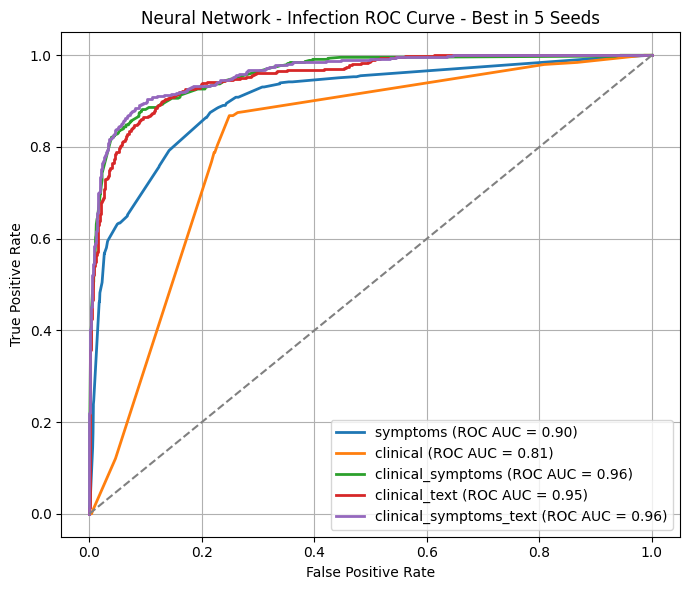

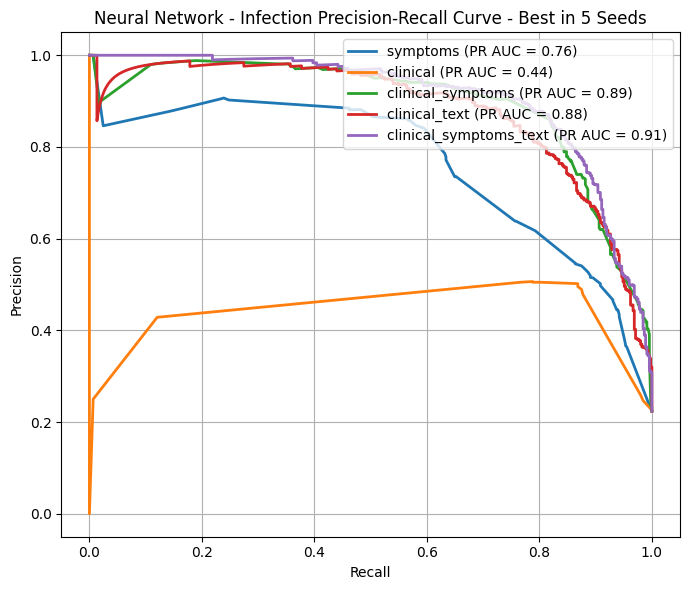

In [14]:
# In kết quả tốt nhất của mỗi input_type
print("\n🎯 Best results by input_type (based on PR AUC):")
for input_type, result in all_results.items():
    print(f"  - {input_type:15}: Seed = {result['seed']}, ROC AUC = {result['roc_auc']:.4f}, PR AUC = {result['pr_auc']:.4f}")

# === ROC CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['fpr'], result['tpr'], lw=2,
             label=f"{input_type} (ROC AUC = {result['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network - Infection ROC Curve - Best in 5 Seeds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === PRECISION-RECALL CURVE CHO NHIỀU INPUT_TYPE ===
plt.figure(figsize=(7, 6))
for input_type, result in all_results.items():
    plt.plot(result['recall'], result['precision'], lw=2,
             label=f"{input_type} (PR AUC = {result['pr_auc']:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Neural Network - Infection Precision-Recall Curve - Best in 5 Seeds")
plt.legend(loc="upper right")
plt.grid(True)
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 1, 6))
plt.tight_layout()
plt.show()

